# Import

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [57]:
%cd /content/gdrive/My Drive/Github

/content/gdrive/My Drive/Github


In [58]:
%cd parallel-stencil-unstructured/

/content/gdrive/My Drive/Github/parallel-stencil-unstructured


In [61]:
%ls -a

.git/


In [27]:
!git status

On branch master

No commits yet

nothing to commit (create/copy files and use "git add" to track)


In [63]:
!git add ../../Colab\ Notebooks/Swept with advance clean.ipynb .

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [36]:
!git status

On branch master

No commits yet

nothing to commit (create/copy files and use "git add" to track)


In [62]:
%cd ../../Colab\ Notebooks/
%ls -a

/content/gdrive/My Drive/Colab Notebooks
'16.90 Problem Set 3.ipynb'
 1690_Project2_Submissions.ipynb
'16.90 Project 3'
'1D Jacobi.ipynb'
 alice_net.ipynb
 bob_net.ipynb
 chelsea_net.ipynb
'CJM vs SRJ.ipynb'
'Conjugate Gradient.ipynb'
'Copy of airfoil mesh decomposition'
 daniel_net.ipynb
'Deep Q-Learning Tutorials'/
'Digit Classification.ipynb'
'Digit Classification w  Q-network.ipynb'
 Dummy.ipynb
 eric_net.ipynb
'GPU Project'/
'GPU SRJ Performance.ipynb'
 hw3_template.ipynb
'Learning Conjugate Gradient.ipynb'
 Multigrid-2D.ipynb
 Multigrid.ipynb
'My Scheduled Relaxation Spectrum'
 plot.ipynb
'Project 1 Submissions'
'Q-Network Learning.ipynb'
 Research/
'Richardson, Chebyshev, and SRJ'
'RL for Jacobi Relaxation.ipynb'
'Scheduled Relaxation.ipynb'
'Scheduled Relaxation Spectrum (all M)'
'SRJ Data Analysis'
'SRJ Data Analysis (all M)'
'SRJ for Nonsymmetric Matrices.ipynb'
'SRJ on Unstructured Matrices.ipynb'
'SRJ with General Matrices'
'Swept Rule Unstructured.ipynb'
'Swept with advanc

In [ ]:
from pylab import *
from numpy import *
import scipy.io
from random import shuffle
from collections import defaultdict

In [ ]:
pip install pymetis

     |████████████████████████████████| 307kB 6.4MB/s 
  Created wheel for pymetis: filename=PyMetis-2020.1-cp37-cp37m-linux_x86_64.whl size=274359 sha256=307a72a76e54d0cdb7a09f7056834a0c6f022bb12aed9ea5a88bf596e956251e
  Stored in directory: /root/.cache/pip/wheels/c6/95/04/af8144c2245c7562e1cc279b59ca502ff702f04184eb6ea9cf
Successfully built pymetis


In [ ]:
import pymetis

# Helper Functions

## Neighbors and xy coordinates

In [4]:
def create2Dneighbors(N, periodic=True, diagonalLinks=True):
    neighbors = defaultdict(set)
    for j in range(N):
        for i in range(N):
            dof = i + N*j
            # Left and right neighbors
            left = ((i-1) % N)+ N*j
            right = ((i+1) % N)+ N*j
            # Top and bottom neighbors
            top = i + N*((j+1) % N)
            bottom = i + N*((j-1) % N)
            # Diagonal neighbors
            ne = ((i+1) % N) + N*((j+1) % N)
            nw = ((i-1) % N) + N*((j+1) % N)
            se = ((i+1) % N) + N*((j-1) % N)
            sw = ((i-1) % N) + N*((j-1) % N)
            # Add all the neighbors
            if diagonalLinks == True:
                if periodic == True:
                    neighbors[dof].add(left)
                    neighbors[dof].add(right)
                    neighbors[dof].add(top)
                    neighbors[dof].add(bottom)
                    neighbors[dof].add(ne)
                    neighbors[dof].add(nw)
                    neighbors[dof].add(se)
                    neighbors[dof].add(sw)
                else:
                    if i > 0:
                        neighbors[dof].add(left)
                    if i < N-1:
                        neighbors[dof].add(right)
                    if j < N-1:
                        neighbors[dof].add(top)
                    if j > 0:
                        neighbors[dof].add(bottom)
                    # if dof != N*N-1:
                    if i < N-1 and j < N-1:
                        neighbors[dof].add(ne)
                    # if dof != N*N-N:
                    if i > 0 and j < N-1:
                        neighbors[dof].add(nw)
                    # if dof != N-1:
                    if i < N-1 and j > 0:
                        neighbors[dof].add(se)
                    # if dof != 0:
                    if i > 0 and j > 0:
                        neighbors[dof].add(sw)
            else:
                if periodic == True:
                    neighbors[dof].add(left)
                    neighbors[dof].add(right)
                    neighbors[dof].add(top)
                    neighbors[dof].add(bottom)
                else:
                    if i > 0:
                        neighbors[dof].add(left)
                    if i < N-1:
                        neighbors[dof].add(right)
                    if j < N-1:
                        neighbors[dof].add(top)
                    if j > 0:
                        neighbors[dof].add(bottom)
    return neighbors

def coordinatesRectangle(N):
    xy = np.zeros((N*N,2))
    dx = 1.0/N
    x = np.linspace(dx/2,1.0-dx/2,N)
    for dof in arange(len(neighbors)):
        idx = int(dof % N)
        idy = int(dof / N)
        xy[dof,:] = np.array((x[idx], x[idy]))
    return xy

## Advance Function

In [5]:
def advance(seeds, nIters, groundLevel):
    fronts = [{1:set(s)} for s in seeds]
    territories = -ones(len(neighbors), int)
    for i in range(len(seeds)):
        # print("The " + str(i) + "th seed")
        for p in seeds[i]:
            territories[p] = i
            # print("DOF " + str(p))
    stopper = set()
    iIter = 0
    while iIter + 1 != nIters:
        for iSeed in range(len(seeds)):
            fronts[iSeed][0] = set()
            for ilevel in range(iIter+1, 0, -1):
                for pFront in fronts[iSeed][ilevel]:
                    for pNbr in neighbors[pFront]:
                        if territories[pNbr] < 0 and groundLevel[pNbr] < ilevel:
                            fronts[iSeed][ilevel-1].add(pNbr)
                            territories[pNbr] = iSeed
                        elif territories[pNbr] != iSeed and groundLevel[pNbr] < ilevel:
                            stopper.add(pNbr)
            for ilevel in range(iIter+1, -1, -1):
                fronts[iSeed][ilevel+1] = fronts[iSeed][ilevel]
            del fronts[iSeed][0] 
        if len(stopper):
            break
        iIter = iIter+1
    return iIter, territories, array(list(stopper)), fronts

def checkTerritoriesIntersect(territories):
    territoriesIntersect = False
    numSubdomains = np.max(territories)
    territoriesDofs = []
    for s in np.arange(numSubdomains):
        dofs = np.where(territories == s)
        for dof in dofs[0]:
            for neighbor in list(neighbors[dof]):
                if territories[neighbor] != -1 and territories[neighbor] != s:
                    territoriesIntersect = True
    return territoriesIntersect

def advanceNotAdjacent(seeds, nIters):
    fronts = [{1:set(s)} for s in seeds]
    territories = -ones(len(neighbors), int)
    for i in range(len(seeds)):
        for p in seeds[i]:
            territories[p] = i
    territoriesOld = territories.copy()
    stopper = set()
    iIter = 0
    while iIter + 1 != nIters:
        for iSeed in range(len(seeds)):
            fronts[iSeed][0] = set()
            for ilevel in range(iIter+1, 0, -1):
                for pFront in fronts[iSeed][ilevel]:
                    for pNbr in neighbors[pFront]:
                        if territories[pNbr] < 0:
                            fronts[iSeed][ilevel-1].add(pNbr)
                            territories[pNbr] = iSeed
                        elif territories[pNbr] != iSeed:
                            stopper.add(pNbr)
            for ilevel in range(iIter+1, -1, -1):
                fronts[iSeed][ilevel+1] = fronts[iSeed][ilevel]
            del fronts[iSeed][0] 
        territoriesIntersect = checkTerritoriesIntersect(territories)
        if territoriesIntersect == True:
            break
        territoriesOld = territories.copy()
        iIter = iIter+1
    return iIter, territoriesOld, array(list(stopper)), fronts

def frontsToGroundLevel(fronts):
    for front in fronts:
        for level, points in front.items():
            for point in points:
                groundLevel[point] = level-1
    return groundLevel

## Finding seeds

In [6]:
# STEPS:
# 1 - For each seed set, obtain all the possible neighbors - OK
# 2 - Given the seed set and the possible neighbors, loop through neighbors - OK
# 3 - For each neighbor, add it to the path. Find the next neighbor that is (a) neighbor of current dof, (b) in filament, (c) not seed
# 4 - Determine the dx and dy, and check if the most recent dof has any dof perpendicular to it and add that to the path
# 5 - Loop 3 and 4 until we are about to add a neighbor that is in the seedsList (dont add it and end the path)

def findSeeds(N, nSubdomains):
    # Create array containing how many DOFs per subdomain
    pointsInSubdomain = zeros(nSubdomains, dtype=int)
    nPerSubdomain = round(N / nSubdomains)
    for i in arange(nSubdomains):
        pointsInSubdomain[i] = int(nPerSubdomain)
    if sum(pointsInSubdomain) != N:
        lastNumberOfDofs = N - sum(pointsInSubdomain[:-1])
        pointsInSubdomain[-1] = int(lastNumberOfDofs)
    count = 0
    while abs(pointsInSubdomain[-1] - nPerSubdomain) > 1:
        if pointsInSubdomain[-1] - nPerSubdomain > 1:
            pointsInSubdomain[-1] -= 1
            pointsInSubdomain[count] += 1
        elif nPerSubdomain - pointsInSubdomain[-1] > 1:
            pointsInSubdomain[-1] += 1
            pointsInSubdomain[count] -= 1
        count += 1
    pointsInSubdomain = np.array(sorted(pointsInSubdomain))
    # Partition domain into the subdomains
    domain = zeros((N,N), dtype=int)
    for j in arange(N):
        for i in arange(N):
            domain[i, j] = int(j + i * N)
    subdomainList = []
    for i in arange(nSubdomains):
        for j in arange(nSubdomains):
            xInit = sum(pointsInSubdomain[0:i])
            xFinal = sum(pointsInSubdomain[0:i+1])
            yInit = sum(pointsInSubdomain[0:j])
            yFinal = sum(pointsInSubdomain[0:j+1])
            subdomain = domain[xInit : xFinal, yInit : yFinal]
            subdomainList.append(subdomain)
    # Determine the seed dofs corresponding to each subdomain
    seeds = []
    # Modified approach - working on it
    # (a): Iterate on subdomains to see how many iterations can be performed
    iterationList = []
    for subdomain in subdomainList:
        subdomain = list(np.concatenate(subdomain))
        iter = 0
        while len(subdomain) > 0:
            iter = iter + 1
            subdomainNext = []
            subdomainCurr = subdomain
            for dof in subdomain:
                addToNext = True
                for neighbor in neighbors[dof]:
                    if neighbor not in subdomain:
                        addToNext = False
                if addToNext == True:
                    subdomainNext.append(dof)
            subdomain = subdomainNext
        iterationList.append(iter)
    # (b): Perform number of iterations that is minumum for all sets to the 
    # the appropriate seed
    iterationsToDo = min(iterationList) 
    for i in arange(len(subdomainList)):
        subdomain = subdomainList[i]
        subdomain = list(np.concatenate(subdomain))
        for iter in arange(iterationsToDo):
            subdomainNext = []
            subdomainCurr = subdomain
            for dof in subdomain:
                addToNext = True
                for neighbor in neighbors[dof]:
                    if neighbor not in subdomain:
                        addToNext = False
                if addToNext == True:
                    subdomainNext.append(dof)
            subdomain = subdomainNext
        seeds.append(set(subdomainCurr))
    return seeds

## STEPS
# 1 - determine the lowest level region and pick a random point
# 2 - check all points that lie in region and also are neighbors of that poit
# 3 - check what territories each of the dofs in step 2 are associated with
# 4 - if 4 different territories are present, keep track of the territories. Add our
# original point and its territory. For each dof, if it is part of a new territory
# add the dof and record the territory
# 5 - Check that the four dofs are neighbors of one another
def findSeedsDual(groundLevel, territories):
    dualDofs = []
    nIters = 1000
    for iter in arange(nIters):
        # STEP 1
        minIter = min(groundLevel)
        potentialDualDof = set(np.where(groundLevel == minIter)[0])
        dualDofInit = random.choice(list(potentialDualDof))
        # STEP 2
        neighborsOfDualDofInit = neighbors[dualDofInit]
        dualDofsAttached = potentialDualDof.intersection(neighborsOfDualDofInit)
        # STEP 3
        territoryIDs = set()
        territoryInit = territories[dualDofInit]
        territoryIDs.add(territoryInit)
        for dof in dualDofsAttached:
            territoryID = territories[dof] 
            territoryIDs.add(territoryID)
        # STEP 4
        if len(territoryIDs) == 4:
            territoryTracker = [territoryInit]
            dofTracker = [dualDofInit]
            dualDofsAttached = list(dualDofsAttached)
            random.shuffle(dualDofsAttached)
            for dof in dualDofsAttached:
                territory = territories[dof]
                if territory not in territoryTracker:
                    territoryTracker.append(territory)
                    dofTracker.append(dof)
            #print(dofTracker)
            # STEP 5
            acceptDualDof = True
            for dofMain in dofTracker:   
                for dofSub in dofTracker:
                    if dofMain != dofSub:
                        if dofSub not in neighbors[dofMain]:
                            acceptDualDof = False
            # Add the dualDof if accept dual dof is true
            dualDofsToAdd = set(dofTracker)
            if acceptDualDof == True and dualDofsToAdd not in dualDofs:
                dualDofs.append(set(dofTracker))

    return dualDofs

def simpleBridges(filament, seeds):
    allSeeds = set()
    for i in arange(len(seeds)):
        allSeeds.update(seeds[i])
    allBridges = []
    allBridges = filament.difference(allSeeds)   
    return allBridges

## Plotting

In [7]:
def plotGroundLevel(groundLevel, N):
    figure()
    imshow(reshape(groundLevel, [N,N]))
    colorbar()
    return

def plotSeeds(seedsSet, N):
    ground = zeros(N*N)
    for seed in seedsSet:
        dof = list(seed)
        ground[dof] = 1
    figure()
    imshow(reshape(ground,[N,N]))

def plotBridges(bridgesList, N):
    for bridge in bridgesList:
        ground = zeros(N*N)
        dofs = list(bridge)
        ground[dofs] = 1
        figure()
        imshow(reshape(ground,[N,N]))

def plotTerritories(territories, N):
    for i in arange(0,max(territories)+1):
        ground = zeros(N*N)
        dofs = np.where(territories == i)[0]
        ground[dofs] = 1
        figure()
        imshow(reshape(ground,[N,N]))

def plotTerritoriesAll(territories, N):
    ground = zeros(N*N)
    for i in arange(0,max(territories)+1):
        dofs = np.where(territories == i)[0]
        ground[dofs] = 1
    figure()
    imshow(reshape(ground,[N,N]))
    colorbar()

def plotTerritoriesSet(territorySet, N):
    for i in range(len(territorySet)):
        ground = zeros(N*N)
        dofs = list(territorySet[i])
        ground[dofs] = 1
        figure()
        imshow(reshape(ground,[N,N]))
        colorbar()

def plotTerritoriesAllSet(territorySet, N):
    ground = zeros(N*N)
    for i in range(len(territorySet)):
        dofs = list(territorySet[i])
        ground[dofs] = 1
    figure()
    imshow(reshape(ground,[N,N]))
    colorbar()

## Parallel Advance Functions

In [8]:
def expandTerritorySet(territorySet, neighbors):
    territorySetExpanded = []
    for i in range(len(territorySet)):
        setToAdd = set()
        for dof in list(territorySet[i]):
            setToAdd.add(dof)
            for neighbor in neighbors[dof]:
                setToAdd.add(neighbor)
        territorySetExpanded.append(setToAdd)
    return territorySetExpanded

def groundLevelPartition(groundLevel, territorySet, seeds, neighbors):
    groundLevelAllSubdomains = []
    for i in range(len(seeds)):
        subdomainListToAdd = defaultdict(list)
        for dof in territorySet[i]:
            subdomainListToAdd[dof] = int(groundLevel[dof])
        groundLevelAllSubdomains.append(subdomainListToAdd)
    return groundLevelAllSubdomains

def parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySet, seeds, nIters, neighbors):
    for i in range(len(seeds)):
        updateList = []
        updateList.append(seeds[i])
        levelStart = min(groundLevel)
        thresholdLevelList = [levelStart+1]
        for iter in range(nIters):
            updateListAll = []
            for idx in range(len(updateList)):
                updateListAll.append(list(updateList[idx]))
            updateListAll = concatenate(updateListAll)
            for s in range(len(updateList)):
                updateSetNext = set()
                for dof in updateList[s]:
                    ## update: check if all my neighbors present in subdomain before doing the update
                    updateDof = True
                    for neighbor in neighbors[dof]:
                        if neighbor not in groundLevelAllSubdomains[i]:
                            updateDof = False
                    currentLevel = groundLevelAllSubdomains[i][dof]
                    if currentLevel < thresholdLevelList[s] and updateDof == True:
                        groundLevelAllSubdomains[i][dof] = groundLevelAllSubdomains[i][dof] + 1
                        for neighbor in neighbors[dof]:
                            if neighbor in groundLevelAllSubdomains[i] and neighbor not in updateListAll:
                                if groundLevelAllSubdomains[i][neighbor] < thresholdLevelList[s]:
                                    if s < len(updateList)-1:
                                        updateList[s+1].add(neighbor)
                                    else:
                                        updateSetNext.add(neighbor)                                    
            for idx2 in range(len(thresholdLevelList)):
                thresholdLevelList[idx2] += 1
            thresholdLevelList.append(levelStart+1)
            updateList.append(updateSetNext)
            
    return groundLevelAllSubdomains

def groundLevelCombine(groundLevelInput, groundLevelAllSubdomains, territorySet = []):
    groundLevel = groundLevelInput.copy()
    for i in range(len(groundLevelAllSubdomains)):
        for dof in groundLevelAllSubdomains[i]:
            if len(territorySet) == 0:
                groundLevel[dof] = groundLevelAllSubdomains[i][dof]
            elif dof in territorySet[i]:
                groundLevel[dof] = groundLevelAllSubdomains[i][dof]
    return groundLevel

# STEP 1: UPPER PYRAMIDAL

## Functions

In [9]:
def findSeedsApart(neighbors, numSeeds):
    # Initialize stuff
    numDofs = len(neighbors)
    seeds = random.choice(numDofs, size=numSeeds, replace=False)
    seeds = [set([s]) for s in seeds]
    groundLevel = zeros(numDofs)
    maxIter = 0
    # Figure out how far apart (how many iters max) can be done
    for trial in range(2000):
        iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)
        if iIter > maxIter:
            print(iIter)
            maxIter = iIter
        _, territories2,_,_ = advance([stopper], iIter+1, groundLevel)
        seeds = moveSeeds(seeds, territories2)
    # Find a seed configuration corresponding to this max iter
    iIter = 0
    while iIter < maxIter:
        _, territories2,_,_ = advance([stopper], iIter+1, groundLevel)
        seeds = moveSeeds(seeds, territories2)
        iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)
    return seeds

def createSubdomainsWithMETIS(neighbors, seeds, territories):
    # Create useful data structures containing seed, territory info
    territorySet = territorySetCreator(territories)
    seedsList, territoryList = seedAndTerritoryListCreator(seeds, territorySet)
    # Remove all neighbors of nodes lying in a territory
    for i in range(len(seeds)):
        for dof in territorySet[i]:
            neighbors[dof].clear()
    # Link seeds to all neighbors of the territory dofs
    neighborsOfTerritory = getNeighborsOfTerritory(seeds, territorySet)
    for i in range(len(seeds)):
        seedDof = list(seeds[i])[0]
        neighbors[seedDof] = set(neighborsOfTerritory[i])
    # Replace any territory dof in the connectivity with the representative seed
    for dof in range(len(neighbors)):
        for neighbor in neighbors[dof].copy():
            for i in range(len(seeds)):
                if neighbor in territorySet[i]:
                    neighbors[dof].remove(neighbor)
                    neighbors[dof].add(list(seeds[i])[0])
    # Create METIS adjacency list and vweights data structures (arrays)
    adjacency_list = []
    vweights = []
    ratioNonSeedToSeed = int(numDofs - len(seeds) / len(seeds))
    hugeFactor = 10000
    seedWeight = hugeFactor * ratioNonSeedToSeed
    for i in range(numDofs):
        adjacency_list.append(np.array(list(neighborsDummy[i])))
        if i in seedsList:
            vweights.append(seedWeight)
        else:
            vweights.append(1)
    # Use METIS to partition the domain
    numSubdomains = len(seeds)
    territorySetAllDofs = []
    n_cuts, membership = pymetis.part_graph(numSubdomains, adjacency=adjacency_list, vweights=vweights)
    for i in range(numSubdomains):
        nodes_partition = np.argwhere(np.array(membership) == i).ravel() # [3, 5, 6]
        territorySetAllDofs.append(set(nodes_partition))
    # Remove dofs which were in the territory but not the seed
    for sub in range(numSubdomains):
        for dof in territorySetAllDofs[sub].copy():
            if (dof not in seedsList):
                if dof in territoryList:
                    territorySetAllDofs[sub].remove(dof)
    # In each region, find the seed and augment the list with all the territory dofs corresponding to the seed
    metisToTerritories = []
    for sub in range(numSubdomains):
        for dof in territorySetAllDofs[sub].copy():
            if dof in seedsList:
                idx = np.where(dof == seedsList)[0][0]
                territorySetAllDofs[sub].update(territorySet[idx])
    return territorySetAllDofs

def upperPyramidal(territorySetAllDofs, neighbors):
    numSubdomains = len(territorySetAllDofs)
    iterationList = []
    # Determine max iters that can be performed overall (min of all iters)
    for s in range(numSubdomains):
        iter = 0
        currentDofs = list(territorySetAllDofs[s])
        while len(currentDofs) > 0:
            updatedDofs = []
            for dof in currentDofs:
                updateTheDof = True
                for n in neighbors[dof]:
                    if n not in currentDofs:
                        updateTheDof = False
                if updateTheDof == True:
                    updatedDofs.append(dof)
            currentDofs = updatedDofs
            if len(updatedDofs) > 0:
                iter = iter + 1
        iterationList.append(iter)
    # Obtain seeds from performing that many iterations
    iterationsToDo = min(iterationList) 
    seeds = []
    for s in range(numSubdomains):
        iter = 0
        currentDofs = list(territorySetAllDofs[s])
        for iter in range(iterationsToDo):
            updatedDofs = []
            for dof in currentDofs:
                updateTheDof = True
                for n in neighbors[dof]:
                    if n not in currentDofs:
                        updateTheDof = False
                if updateTheDof == True:
                    updatedDofs.append(dof)
            currentDofs = updatedDofs
        seeds.append(set(currentDofs))
    # Return seed values
    return seeds

In [10]:
def moveSeeds(seeds, territories):
    seedsNew = []
    territoryDofs = set(np.where(territories == 0)[0])
    p = np.random.rand()
    for s in seeds:
        neighborInStopperTerritory = False
        for dof in neighbors[list(s)[0]]:
            if dof in territoryDofs:
                neighborInStopperTerritory = True
        if (list(s)[0] in territoryDofs) or (neighborInStopperTerritory == True):
            potentialSeeds = neighbors[list(s)[0]].difference(territoryDofs)
            if len(potentialSeeds) > 0:
                seedsNew.append(random.choice(list(potentialSeeds)))
            else:
                seedsNew.append(list(s)[0])
        else:
            seedsNew.append(list(s)[0])
    seedsNew = [set([s]) for s in seedsNew]
    return seedsNew

def territorySetCreator(territories):
    territorySet = []
    for i in range(max(territories)+1):
        territoryDofs = set(np.where(territories == i)[0])
        territorySet.append(territoryDofs)
    return territorySet

def seedAndTerritoryListCreator(seeds, territorySet):
    seedsList = []
    territoryList = []
    for i in range(len(seeds)):
        seedsList.append(list(seeds[i])) 
        territoryList.append(list(territorySet[i]))
    seedsList = np.concatenate(seedsList)
    territoryList = np.concatenate(territoryList)
    return seedsList, territoryList

def getNeighborsOfTerritory(seeds, territorySet):
    neighborsOfTerritory = []
    for i in range(len(seeds)):
        territoryNeighbors = []
        for dof in territorySet[i]:
            territoryNeighbors.append(list(neighbors[dof]))
        neighborsOfTerritory.append(set(np.concatenate(territoryNeighbors)))
    for i in range(len(seeds)):
        neighborsOfTerritory[i] = set(neighborsOfTerritory[i]).difference(set(territorySet[i])) 
    return neighborsOfTerritory

# STEP 2: DUAL SEED UPDATE

## Functions

In [11]:
def findSeedsDual(groundLevel, territorySetAllDofs):
    dualDofs = []
    nIters = 1000
    for iter in arange(nIters):
        # STEP 1
        minIter = min(groundLevel)
        potentialDualDof = set(np.where(groundLevel == minIter)[0])
        potentialDualDof.update(set(np.where(groundLevel == minIter+1)[0]))
        dualDofInit = random.choice(list(potentialDualDof))
        # STEP 2
        neighborsOfDualDofInit = neighbors[dualDofInit]
        dualDofsAttached = potentialDualDof.intersection(neighborsOfDualDofInit)
        # STEP 3
        territoryIDs = set()
        territoryInit = territoryFinder(territorySetAllDofs, dualDofInit) # territories[dualDofInit]
        territoryIDs.add(territoryInit)
        for dof in dualDofsAttached:
            territoryID =  territoryFinder(territorySetAllDofs, dof) # territories[dof] 
            territoryIDs.add(territoryID)
        # STEP 4
        if len(territoryIDs) > 2:
            territoryTracker = [territoryInit]
            dofTracker = [dualDofInit]
            dualDofsAttached = list(dualDofsAttached)
            random.shuffle(dualDofsAttached)
            for dof in dualDofsAttached:
                territory =  territoryFinder(territorySetAllDofs, dof) # territories[dof]
                if territory not in territoryTracker:
                    territoryTracker.append(territory)
                    dofTracker.append(dof)
            #print(dofTracker)
            # STEP 5
            acceptDualDof = True
            for dofMain in dofTracker:   
                for dofSub in dofTracker:
                    if dofMain != dofSub:
                        if dofSub not in neighbors[dofMain]:
                            acceptDualDof = False
            # Add the dualDof if accept dual dof is true
            dualDofsToAdd = set(dofTracker)
            if acceptDualDof == True and dualDofsToAdd not in dualDofs:
                dualDofs.append(set(dofTracker))
    return dualDofs

def removeAdjacentDualSeeds(dualSeeds, neighbors):
    dualSeedIDArray = -ones(len(dualSeeds))
    ID = -1
    for i in range(len(dualSeeds)):
        if dualSeedIDArray[i] == -1:
            ID = ID + 1
            dualSeed1 = dualSeeds[i]
            dualSeedIDArray[i] = ID
            for j in range(len(dualSeeds)):
                dualSeed2 = dualSeeds[j]
                if dualSeed1 != dualSeed2:
                    for dof in dualSeed1:
                        for neighbor in neighbors[dof]:
                            if neighbor in dualSeed2:
                                dualSeedIDArray[j] = ID
    dualSeedsNonAdjacent = []
    print(dualSeedIDArray)
    for ID in range(int(max(dualSeedIDArray)+1)):
        possibleSeeds = np.where(dualSeedIDArray == ID)[0]
        print(possibleSeeds)
        seedID = random.choice(possibleSeeds)
        dualSeedsNonAdjacent.append(dualSeeds[seedID])
    return dualSeedsNonAdjacent

def obtainFilamentBridgeRegion(dualSeeds, groundLevel):
    iIter, territories, stopper, fronts = advanceNotAdjacent(dualSeeds, max(groundLevel))
    figure()
    imshow(reshape(territories >= 0, [N,N]))
    colorbar()
    filament = set(np.where(territories == -1)[0])  
    return filament

def filamentRemoveSeeds(filament, seeds):
    for i in range(len(seeds)):
        filament.difference_update(seeds[i])
    return filament

def territoryFinder(territorySetAllDofs, dof):
    territoryID = -1
    for i in range(len(territorySetAllDofs)):
        if dof in territorySetAllDofs[i]:
            territoryID = i
    if territoryID == -1:
        print("A territory wasn't found")
    return territoryID

In [12]:
def filamentConnectivityConstructor(filament, neighbors, groundLevel):
    filamentConnectivity = defaultdict()
    for dof in filament:
        allNeighbors = set()
        currentLevel = int(groundLevel[dof])
        maxLevel = int(max(groundLevel))
        mylist = set()
        if currentLevel < maxLevel:
            mylist.add(dof)
        levelGap = 1
        while len(mylist) > 0:
            lowDofs = set()
            for dofIter in mylist:
                for neighbor in neighbors[dofIter]:
                    allNeighbors.add(neighbor)
                    if groundLevel[neighbor] < maxLevel-levelGap:
                        lowDofs.add(neighbor)
            mylist = lowDofs.copy()
            levelGap += 1
        filamentConnectivity[dof] = allNeighbors
    return filamentConnectivity

# Construct a graph connecting all dofs in filaments to all other dofs, with weighting equal to intersection of regions of dependence
def filamentMappingforMETIS(filament):
    map = defaultdict()
    reverseMap = defaultdict()
    i = 0
    for dof in filament:
        map[dof] = i
        reverseMap[i] = dof 
        i += 1
    return map, reverseMap

def constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map):
    filamentMapped = set()
    filamentConnectivityMapped = defaultdict()
    for dof in filament:
        filamentMapped.add(map[dof])
        filamentConnectivityMapped[map[dof]] = filamentConnectivity[dof]
    return filamentMapped, filamentConnectivityMapped

def constructMETISDataStructures(filamentMapped, filamentConnectivityMapped):
    xadj = []
    adjncy = []
    eweights = []
    for dof in filamentMapped:
        xadj.append(len(adjncy))
        filamentMappedNoDof = filamentMapped.difference({dof})
        for dof2 in filamentMappedNoDof:
            adjncy.append(dof2)
            eweights.append(len(filamentConnectivityMapped[dof].intersection(filamentConnectivityMapped[dof2])))
    xadj.append(len(adjncy))
    return xadj, adjncy, eweights

def membershipToBridges(nparts, membership, reverseMap):
    bridges = []
    for IDno in range(nparts):
        bridgeSet = set()
        for dof in range(len(membership)):
            ID = membership[dof]
            if ID == IDno:
                actualDof = reverseMap[dof]
                bridgeSet.add(actualDof)
        bridges.append(bridgeSet)
    return bridges

## Test Case of Bridge Connectivity

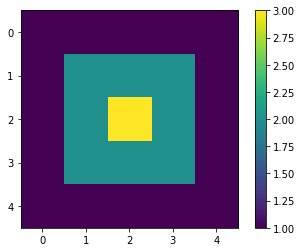

In [ ]:
## MAIN ##

# Initialization 
N = 5
nSubdomains = 1
periodicFlag = False
diagonalLinksFlag = True
neighbors = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
seeds = [{int(N*N/2)}]

# Advance!
groundLevel = zeros(N*N)
iIter, territories, stopper, fronts = advance(seeds, 4, groundLevel)
groundLevel = frontsToGroundLevel(fronts)
plotGroundLevel(groundLevel, N)

In [ ]:
# Define all points in filament
filament = set()
filament.update(arange(N*N))
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
print(filamentConnectivity)

defaultdict(None, {0: {0, 1, 2, 5, 6, 7, 10, 11}, 1: {0, 1, 2, 3, 5, 6, 7, 8, 10, 11}, 2: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, 3: {1, 2, 3, 4, 6, 7, 8, 9, 13, 14}, 4: {2, 3, 4, 7, 8, 9, 13, 14}, 5: {0, 1, 2, 5, 6, 7, 10, 11, 15, 16}, 6: {0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 15, 16}, 7: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 8: {1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 18, 19}, 9: {2, 3, 4, 7, 8, 9, 13, 14, 18, 19}, 10: {0, 1, 5, 6, 10, 11, 15, 16, 20, 21}, 11: {0, 1, 5, 6, 7, 10, 11, 12, 15, 16, 17, 20, 21}, 12: set(), 13: {3, 4, 7, 8, 9, 12, 13, 14, 17, 18, 19, 23, 24}, 14: {3, 4, 8, 9, 13, 14, 18, 19, 23, 24}, 15: {5, 6, 10, 11, 15, 16, 17, 20, 21, 22}, 16: {5, 6, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23}, 17: {11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}, 18: {8, 9, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24}, 19: {8, 9, 13, 14, 17, 18, 19, 22, 23, 24}, 20: {10, 11, 15, 16, 17, 20, 21, 22}, 21: {10, 11, 15, 16, 17, 18, 20, 21, 22, 23}, 22: {15, 16, 17, 18, 19, 20, 21, 22, 23, 24}

# STEP 3: LOWER PYRAMIDAL

## Functions

In [13]:
def lowerPyramidal(neighbors, groundLevel):
    seeds = []
    minIter = min(groundLevel)
    for dof in range(N*N):
        if groundLevel[dof] == minIter:
            seedList = [dof]
            for neighbor in neighbors[dof]:
                if groundLevel[neighbor] == minIter:
                    seedList.append(neighbor)
            if set(seedList) not in seeds:
                seeds.append(set(seedList))
    nIters = 2*max(groundLevel) + 1
    iIter, territories, stopper, fronts = advance(seeds, nIters, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)
    return groundLevel

# STEP 4: DUAL BRIDGES

# STEP 5: (Repeat step 1)

# MAIN

## INITIALIZE

In [14]:
# Initialization 
N = 15
nSubdomains = 9
periodicFlag = False
diagonalLinksFlag = True
neighbors = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
PARALLEL_FLAG = True

## STEP 1: UPPER PYRAMIDAL


1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


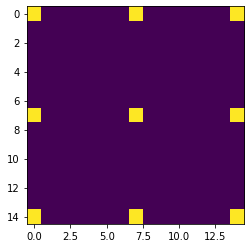

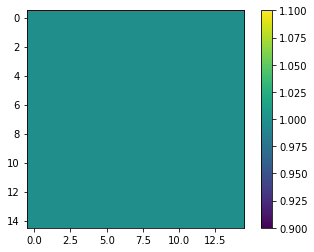

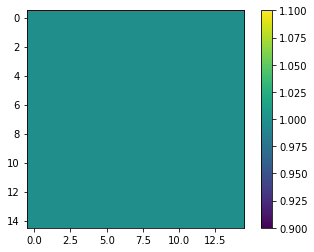

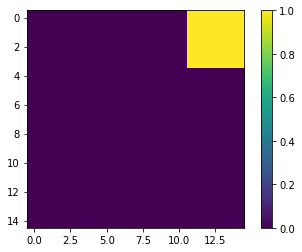

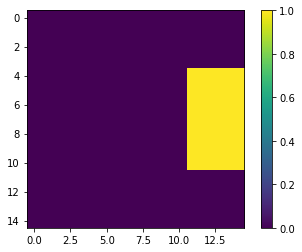

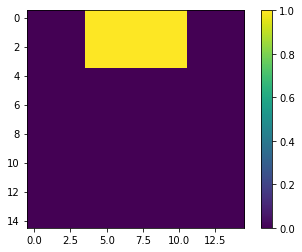

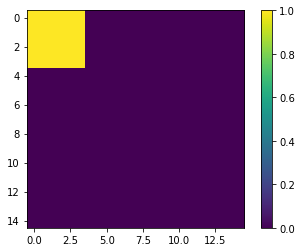

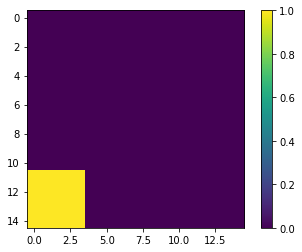

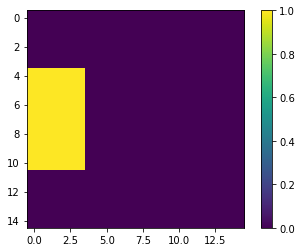

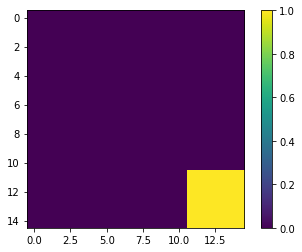

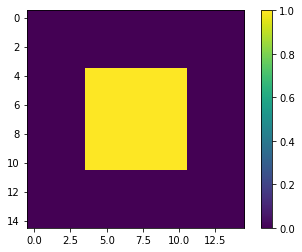

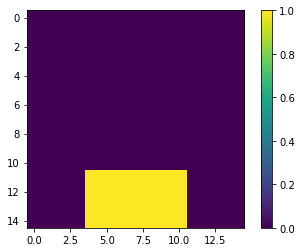

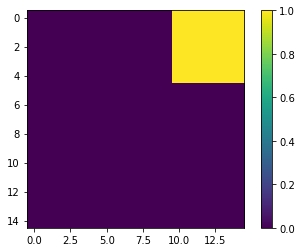

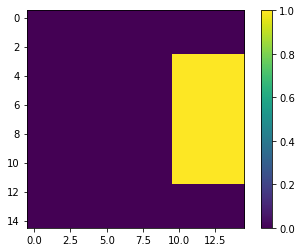

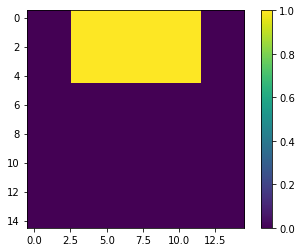

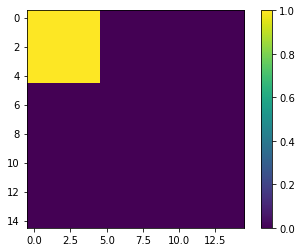

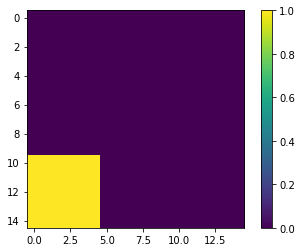

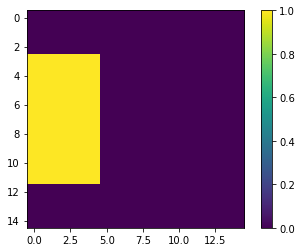

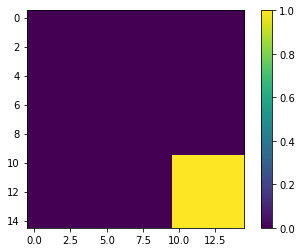

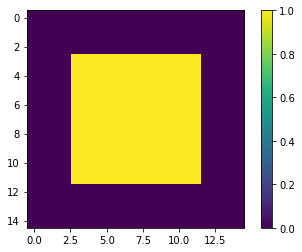

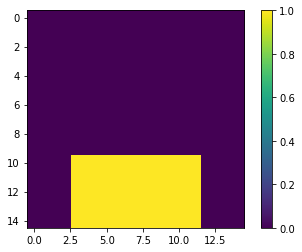

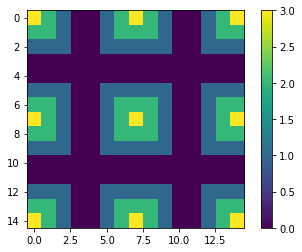

In [22]:
## STAGE 1: UPPER PYRAMIDAL MAIN ##

# Find the far apart seeds
seeds = findSeedsApart(neighbors, nSubdomains)
plotSeeds(seeds,N)

# Use advance to obtain territories
numDofs = len(neighbors)
groundLevel = zeros(numDofs)
iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)
plotTerritoriesAll(territories, N)
# Use pyMETIS to ensure all dofs have an associated subdomain

neighborsDummy = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
territorySetUpperPyramidal = createSubdomainsWithMETIS(neighborsDummy, seeds, territories)
plotTerritoriesAllSet(territorySetUpperPyramidal, N)
plotTerritoriesSet(territorySetUpperPyramidal, N)
territorySetUpperPyramidalExpanded = expandTerritorySet(territorySetUpperPyramidal, neighbors)
plotTerritoriesSet(territorySetUpperPyramidalExpanded, N)

# Obtain the seed dofs for each subdomain
seeds = upperPyramidal(territorySetUpperPyramidal, neighbors)

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetUpperPyramidal, seeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, neighbors, territorySetUpperPyramidal, seeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetUpperPyramidal)
else:
    iIter, territories, stopper, fronts = advance(seeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)
    
# Plot Ground Level    
plotGroundLevel(groundLevel, N)

## STEP 2: BRIDGE STAGE 

In [23]:
def findDualSeeds(groundLevel, territorySetUpperPyramidal, neighbors):
    # Find all dofs at the lowest iteration level after upper pyramidal
    minIter = min(groundLevel)
    potentialDualDofs = set(np.where(groundLevel == minIter)[0])
    # Determine which dofs have the most territories represented in the set of points containing their neighbors and themselves
    territoriesRepByDof = numTerritoriesRepByNeighbors(potentialDualDofs, territorySetUpperPyramidal, neighbors)
    dualSeedDofs = potentialDualSeeds(territoriesRepByDof)
    # Group the dual seeds into different sets of points which are contiguous 
    dualSeeds = groupDualSeeds(dualSeedDofs, neighbors)
    return dualSeeds

def numTerritoriesRepByNeighbors(dofSet, territorySetAllDofs, neighbors):
    # Obtain the number of territories represented by dof
    territoriesRepByDof = defaultdict()
    for dof in dofSet:
        territoryIDs = set()
        territoryIDs.add(territoryFinder(territorySetAllDofs, dof))
        neighborSet = neighbors[dof]
        for neighbor in neighborSet:  
            territoryID = territoryFinder(territorySetAllDofs, neighbor) 
            territoryIDs.add(territoryID)
        territoriesRepByDof[dof] = len(territoryIDs)
    return territoriesRepByDof

def potentialDualSeeds(territoriesRepByDof):
    max_value = max(territoriesRepByDof.values())  # maximum value
    print(max_value)
    dualSeedDofs = [k for k, v in territoriesRepByDof.items() if v == max_value] # getting all keys containing the `maximum`
    return dualSeedDofs

def groupDualSeeds(dualSeedDofs, neighbors):  
    dualSeeds = []
    dofSet = set(dualSeedDofs)
    repeat = True
    while(len(dofSet)) > 0:
        seedSet = set()
        seedSet.add(list(dofSet)[0])
        idx = 0
        if repeat == True:
            dofMain = list(seedSet)[idx]
            repeat = False
            for dof2 in list(dofSet):
                if dofMain != dof2:
                    areNeighbors = determineIfDofsAreNeighbors(dofMain, dof2)
                    if areNeighbors == True:
                        seedSet.add(dof2)
                        repeat = True
            if repeat == True:
                idx = idx + 1
        dofSet.difference_update(seedSet)
        dualSeeds.append(seedSet)
    return dualSeeds

def determineIfDofsAreNeighbors(dof1, dof2):
    areNeighbors = False
    neighborSet = neighbors[dof1]
    for neighbor in neighborSet:
        if neighbor == dof2:
            areNeighbors = True
    return areNeighbors

In [24]:
def findSeedsDual(groundLevel, territorySetAllDofs):
    dualDofs = []
    nIters = 1000
    for iter in arange(nIters):
        # STEP 1: Find all dofs in zero iteration set and pick one randomly
        minIter = min(groundLevel)
        potentialDualDof = set(np.where(groundLevel == minIter)[0])
        dualDofInit = random.choice(list(potentialDualDof))
        # STEP 2: Get the neighbors of selected dof who are also in zero set
        neighborsOfDualDofInit = neighbors[dualDofInit]
        dualDofsAttached = potentialDualDof.intersection(neighborsOfDualDofInit)
        # STEP 3: Get the territories of all selected dofs and save 
        territoryIDs = set()
        territoryInit = territoryFinder(territorySetAllDofs, dualDofInit) 
        territoryIDs.add(territoryInit)
        for dof in dualDofsAttached:
            territoryID =  territoryFinder(territorySetAllDofs, dof) 
            territoryIDs.add(territoryID)
        # STEP 4: Obtain partial set of init dof and attached dof all with different territories
        if len(territoryIDs) > 2:
            territoryTracker = [territoryInit]
            dofTracker = [dualDofInit]
            dualDofsAttached = list(dualDofsAttached)
            random.shuffle(dualDofsAttached)
            for dof in dualDofsAttached:
                territory =  territoryFinder(territorySetAllDofs, dof) 
                if territory not in territoryTracker:
                    territoryTracker.append(territory)
                    dofTracker.append(dof)
            #print(dofTracker)
            # STEP 5: Check if all dofs in seed set are neighbors with one another - is this necessary??
            if 0:
              acceptDualDof = True
              for dofMain in dofTracker:   
                  for dofSub in dofTracker:
                      if dofMain != dofSub:
                          if dofSub not in neighbors[dofMain]:
                              acceptDualDof = False
              # Add the dualDof if accept dual dof is true
              dualDofsToAdd = set(dofTracker)
              if acceptDualDof == True and dualDofsToAdd not in dualDofs:
                  dualDofs.append(set(dofTracker))
            else:
                dualDofs.append(set(dofTracker))
    return dualDofs

def obtainFilamentBridgeRegion(dualSeeds, groundLevel):
    iIter, territories, stopper, fronts = advance(dualSeeds, max(groundLevel)-min(groundLevel), zeros(len(groundLevel)))
    figure()
    imshow(reshape(territories >= 0, [N,N]))
    colorbar()
    filament = set(np.where(territories == -1)[0])  
    return filament

4


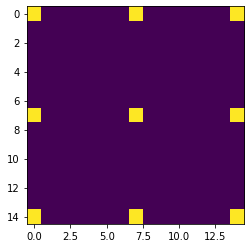

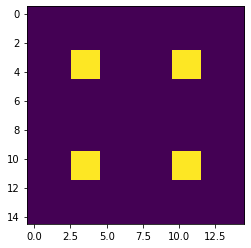

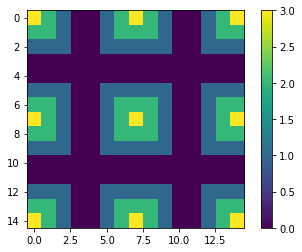

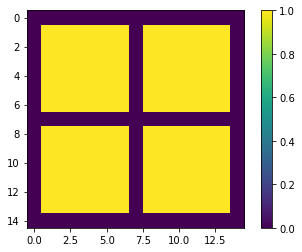

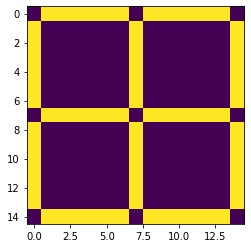

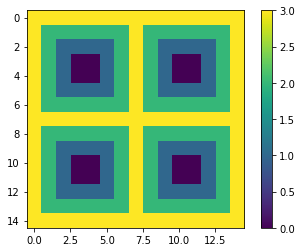

In [25]:
## STAGE 2: BRIDGE STAGE MAIN ##

# Obtain the dual seeds
dualSeeds = findDualSeeds(groundLevel, territorySetUpperPyramidal, neighbors)
#dualSeeds = findSeedsDual(groundLevel, territorySetUpperPyramidal)
#dualSeeds = removeAdjacentDualSeeds(dualSeeds, neighbors)

# Plot the seeds
plotSeeds(seeds, N)
plotSeeds(dualSeeds, N)

# Obtain the filament regions
plotGroundLevel(groundLevel, N)
filament = obtainFilamentBridgeRegion(dualSeeds, groundLevel)
filament = filamentRemoveSeeds(filament, seeds)

# Use METIS to cut the filament region into different pieces
nparts = 1
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
map, reverseMap = filamentMappingforMETIS(filament)
filamentMapped, filamentConnectivityMapped = constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map)
xadj1, adjncy1, eweights1 = constructMETISDataStructures(filamentMapped, filamentConnectivityMapped)
n_cuts, membership = pymetis.part_graph(nparts, xadj=xadj1, adjncy=adjncy1, eweights=eweights1)
bridges = membershipToBridges(nparts, membership, reverseMap)

# Show the bridges
plotBridges(bridges, N)

# Preprocessing
bridgeSeeds = bridges
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
_, territories, stopper, fronts = advance(bridgeSeeds, iIter, groundLevel)
territorySetBridge = territorySetCreator(territories)
#plotTerritoriesAllSet(territorySetBridge, N)
territorySetBridgeExpanded = expandTerritorySet(territorySetBridge, neighbors)

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetBridgeExpanded, bridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetBridgeExpanded, bridgeSeeds, iIter, neighbors) 
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetBridge)
else:
    # Advance using the bridge
    iIter, territories, stopper, fronts = advance(bridgeSeeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
print(territorySetBridge)

[{1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 22, 24, 25, 26, 27, 29, 30, 31, 33, 34, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 78, 79, 81, 82, 83, 85, 86, 88, 89, 90, 92, 93, 94, 95, 97, 99, 100, 101, 102, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 122, 123, 124, 125, 127, 129, 130, 131, 132, 134, 135, 136, 138, 139, 141, 142, 143, 145, 146, 148, 149, 150, 151, 152, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 170, 171, 172, 173, 174, 177, 178, 179, 180, 181, 183, 184, 186, 187, 188, 190, 191, 193, 194, 195, 197, 198, 199, 200, 202, 204, 205, 206, 207, 209, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223}]


## STEP 3: LOWER PYRAMIDAL

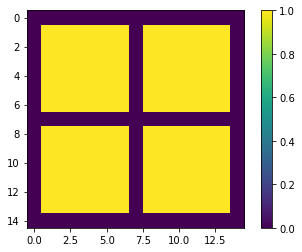

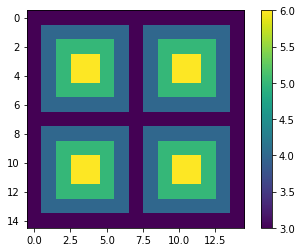

In [26]:
# Preprocessing
iIter = int(max(groundLevel)) - int(min(groundLevel))
_, territories, stopper, fronts = advance(dualSeeds, 2*iIter, groundLevel)
territorySetLowerPyramidal = territorySetCreator(territories)
plotTerritoriesAllSet(territorySetLowerPyramidal, N)
territorySetLowerPyramidalExpanded = expandTerritorySet(territorySetLowerPyramidal, neighbors)

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetLowerPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)

# Plot Ground Level
plotGroundLevel(groundLevel, N)

## STEP 4: DUAL BRIDGES

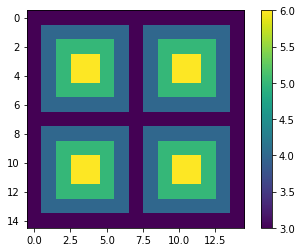

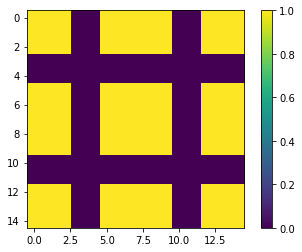

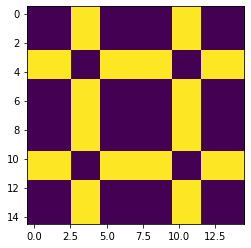

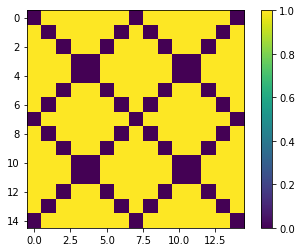

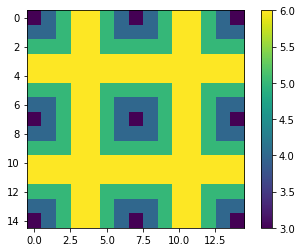

In [27]:
# Obtain the filament regions
plotGroundLevel(groundLevel, N)
filament = obtainFilamentBridgeRegion(seeds, groundLevel)
filament = filamentRemoveSeeds(filament, dualSeeds)

# Use METIS to cut the filament region into different pieces
nparts = 1
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
map, reverseMap = filamentMappingforMETIS(filament)
filamentMapped, filamentConnectivityMapped = constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map)
xadj1, adjncy1, eweights1 = constructMETISDataStructures(filamentMapped, filamentConnectivityMapped)
n_cuts, membership = pymetis.part_graph(nparts, xadj=xadj1, adjncy=adjncy1, eweights=eweights1)
bridges = membershipToBridges(nparts, membership, reverseMap)

# Advance using the bridge
plotBridges(bridges, N)
#iIter, territories, stopper, fronts = advance(bridges, max(groundLevel)+1, groundLevel)
#groundLevel = frontsToGroundLevel(fronts)
#plotGroundLevel(groundLevel, N)

# Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
dualBridgeSeeds = bridges
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
_, territories, stopper, fronts = advance(dualBridgeSeeds, int(max(groundLevel)), groundLevel)
territorySetDualBridge = territorySetCreator(territories)
plotTerritoriesSet(territorySetDualBridge, N)
# from above territorySetUpdateBridge
territorySetDualBridgeExpanded = expandTerritorySet(territorySetDualBridge, neighbors)

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetDualBridge)
else:
    iIter, territories, stopper, fronts = advance([filament], max(groundLevel)+1, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

# Plot Ground Level
plotGroundLevel(groundLevel, N)

## STEP 5: Repeat step 1


In [28]:
def stageAdvance(groundLevel, seeds, territorySet, territorySetExpanded, neighbors, nIters, PARALLEL_FLAG=True):
    if PARALLEL_FLAG == True:
        # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
        groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetExpanded, seeds, neighbors)
        groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetExpanded, seeds, nIters, neighbors)
        groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySet)
    else:
        # Advance
        iIter, territories, stopper, fronts = advance(seeds, 0, groundLevel)
        groundLevel = frontsToGroundLevel(fronts)
    return groundLevel

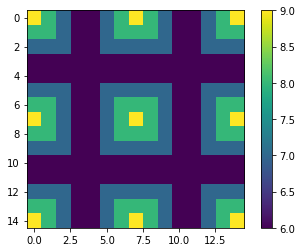

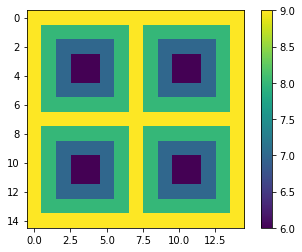

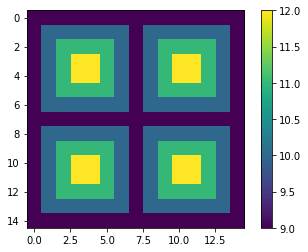

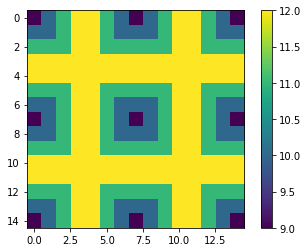

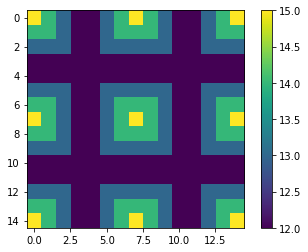

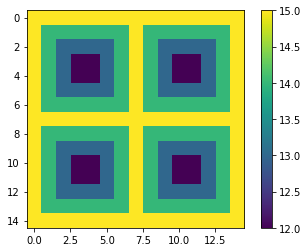

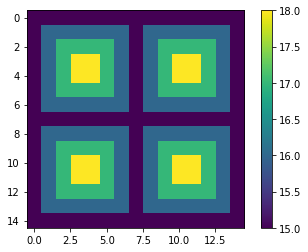

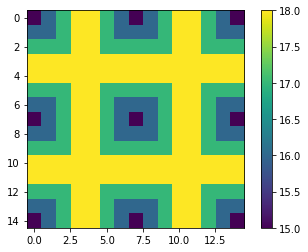

In [29]:
## Repeat upper pyramidal, bridge, lower pyramidal, dual bridge

numCycles = 3
for cycle in arange(1,numCycles):
    ## STAGE 1: UPPER PYRAMIDAL STAGE ##
    groundLevel = stageAdvance(groundLevel, seeds, territorySetUpperPyramidal, territorySetUpperPyramidalExpanded, neighbors, 2*iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 2: BRIDGE STAGE ##
    groundLevel = stageAdvance(groundLevel, bridgeSeeds, territorySetBridge, territorySetBridgeExpanded, neighbors, iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 3: LOWER PYRAMIDAL STAGE ##
    groundLevel = stageAdvance(groundLevel, dualSeeds, territorySetLowerPyramidal, territorySetLowerPyramidalExpanded, neighbors, 2*iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 4: DUAL BRIDGE SEEDS ##
    groundLevel = stageAdvance(groundLevel, dualBridgeSeeds, territorySetDualBridge, territorySetDualBridgeExpanded, neighbors, iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)

### The long way...

In [ ]:
## Repeat upper pyramidal, bridge, lower pyramidal, dual bridge

## STAGE 1: UPPER PYRAMIDAL STAGE ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetUpperPyramidalExpanded, seeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetUpperPyramidalExpanded, seeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetUpperPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)
# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 2: BRIDGE STAGE ##
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetBridgeExpanded, bridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetBridgeExpanded, bridgeSeeds, iIter, neighbors) 
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetBridge)
else:
    # Advance using the bridge
    iIter, territories, stopper, fronts = advance(bridgeSeeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)
# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 3: LOWER PYRAMIDAL STAGE ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetLowerPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)

# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 4: DUAL BRIDGE SEEDS ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetDualBridge)
else:
    iIter, territories, stopper, fronts = advance([filament], max(groundLevel)+1, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

# Plot Ground Level
plotGroundLevel(groundLevel, N)